In [1]:
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score

from sklearn.metrics import f1_score
import random

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
import numpy as np

In [2]:
random.seed(42)

In [3]:
PATH=r"D:\Dokumente\General_Data\other_people\Hard_Metalls\240422-new_data\worked_data\Paper\Data_Sets\\"

In [4]:
X_train = pd.read_csv(f"{PATH}X_train_240722.csv")
y_train = pd.read_csv(f"{PATH}y_train_240722.csv")

In [5]:
y_train = y_train[X_train.mN ==3]
X_train = X_train[X_train.mN ==3]

In [6]:
X_val = pd.read_csv(f"{PATH}X_val_240722.csv")
y_val = pd.read_csv(f"{PATH}y_val_240722.csv")

In [7]:
y_val = y_val[X_val.mN == 3]
X_val = X_val[X_val.mN == 3]

In [8]:
features_trost =  ['slope_0.2',  'norm_slope_0.2',  'curvature','curvature_linear', 'curvature_shift', 'norm_curvature','norm_curvature_linear', 'norm_curvature_shift', 'work_total','work_elastic', 'work_plastic', 'work_ratio', 'h_ratio']

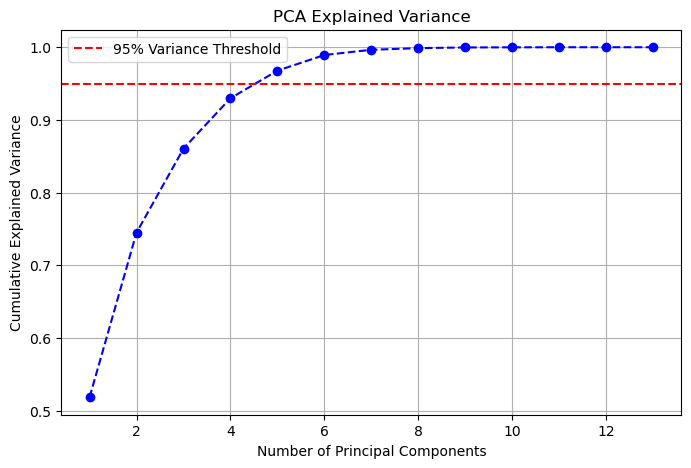

Optimal number of components for 95% variance: 5


In [9]:
scaler= StandardScaler()
X_train[features_trost]=scaler.fit_transform(X_train[features_trost])

# Apply PCA
pca = PCA()
pca.fit(X_train[features_trost])

# Compute cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', color='b')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Variance Threshold")
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

# Find the number of components for 95% variance
optimal_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Optimal number of components for 95% variance: {optimal_components}")

In [10]:
# Step 1: Determine the optimal number of components (from previous analysis)
optimal_components = np.argmax(explained_variance >= 0.95) + 1

# Step 2: Re-run PCA with the optimal number of components
pca_final = PCA(n_components=optimal_components)
X_train_PCA = pca_final.fit_transform(X_train[features_trost])

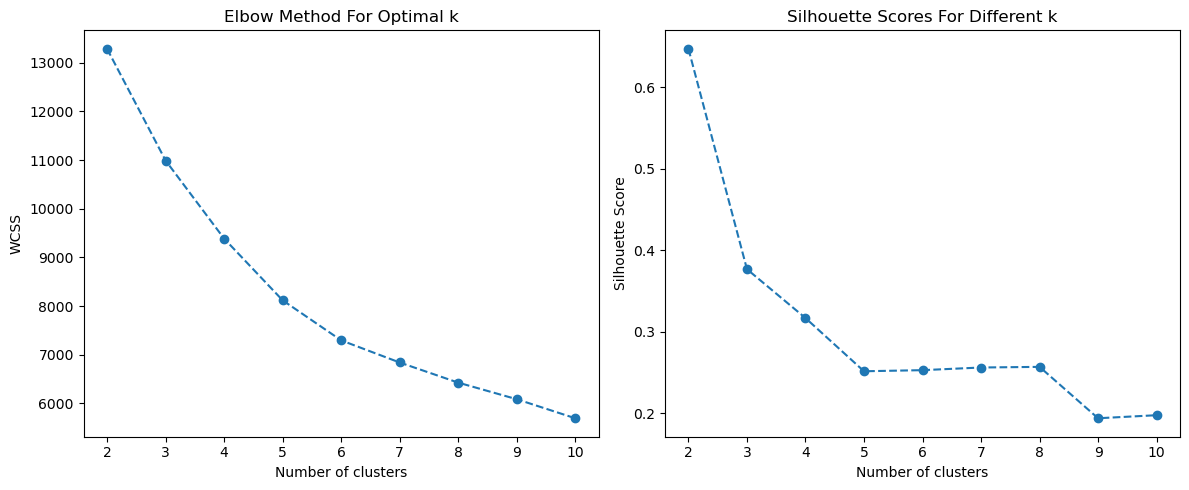

In [11]:
def calculate_wcss_silhouette(data):
    wcss = []
    silhouette_avg = []
    for n in range(2, 11):  # silhouette_score requires at least 2 clusters
        kmeans = KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init=10, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
        cluster_labels = kmeans.labels_
        silhouette_avg.append(silhouette_score(data, cluster_labels))
    return wcss, silhouette_avg

wcss, silhouette_avg = calculate_wcss_silhouette(X_train_PCA)

# 3. Plot the elbow graph for WCSS
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# 4. Plot the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_avg, marker='o', linestyle='--')
plt.title('Silhouette Scores For Different k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [12]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(X_train_PCA)

KMeans(n_clusters=3, n_init=10, random_state=42)

In [13]:
y_train["y_pred"] = kmeans.predict(X_train_PCA)

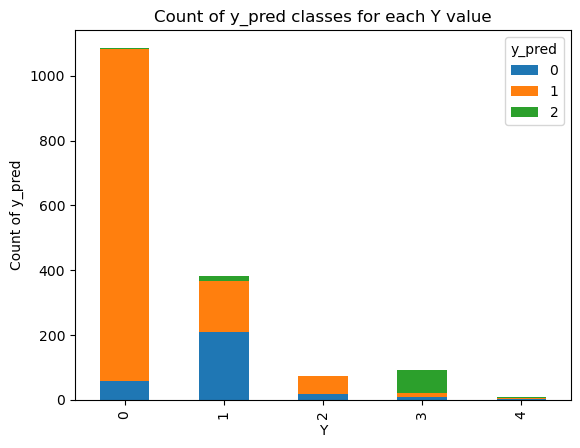

In [14]:
grouped = y_train.groupby(['Y', 'y_pred']).size().unstack(fill_value=0)

# Plotting
grouped.plot(kind='bar', stacked=True)
plt.xlabel('Y')
plt.ylabel('Count of y_pred')
plt.title('Count of y_pred classes for each Y value')
plt.legend(title='y_pred')
plt.show()

In [15]:
encoding = {1:0, 0:1, 2:3}

SV


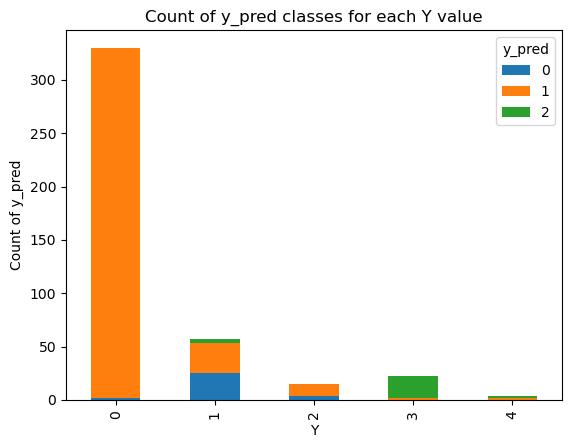

SAV


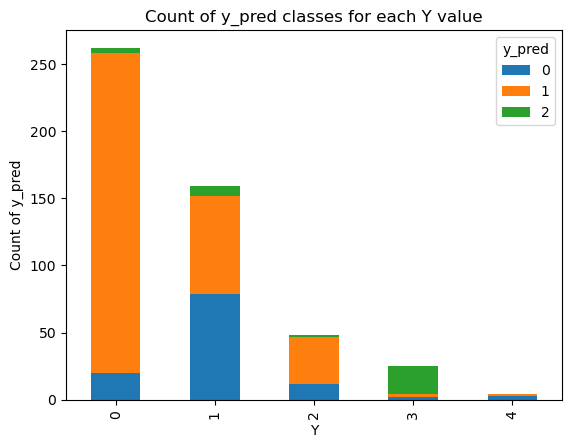

LCV


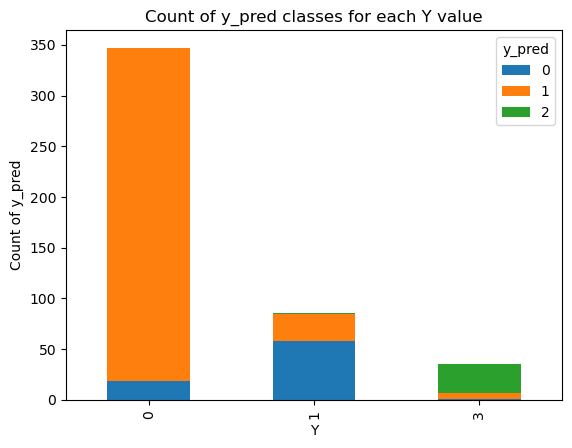

BV


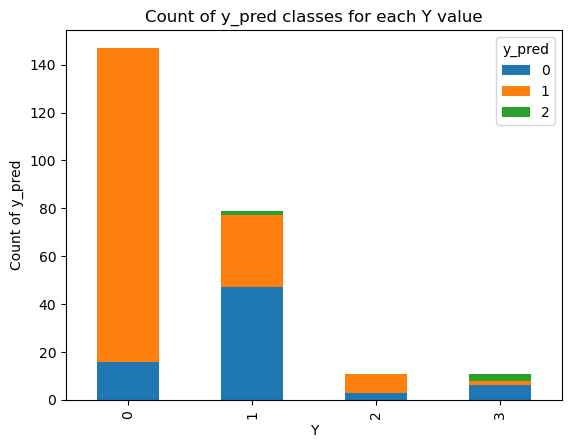

In [16]:
# Sample data

# Assuming df is the DataFrame that contains the data
# If you have the full dataset, load it into the DataFrame
# df = pd.read_csv('path_to_your_dataset.csv')

# Group by 'Y' and 'y_pred' and count the occurrences
for material in X_train.material.unique():
    print(material)
    y_train_plot=y_train[X_train.material == material]
    grouped = y_train_plot.groupby(['Y', 'y_pred']).size().unstack(fill_value=0)
    
    # Plotting
    grouped.plot(kind='bar', stacked=True)
    plt.xlabel('Y')
    plt.ylabel('Count of y_pred')
    plt.title('Count of y_pred classes for each Y value')
    plt.legend(title='y_pred')
    plt.show()

In [17]:
y_train["y_pred_encoded"] = y_train["y_pred"].apply(lambda x: encoding[x])
X_train["y_pred_encoded"] = y_train["y_pred_encoded"]

In [18]:
def calculate_stats(group):
    return pd.DataFrame({
        'material': group['material'].unique()[0],
        'y_pred_encoded': group['y_pred_encoded'].unique()[0],
        'Er(GPa)_mean': group['Er(GPa)'].mean(),
        'Er(GPa)_std': group['Er(GPa)'].std(),
        'H(GPa)_mean': group['H(GPa)'].mean(),
        'H(GPa)_std': group['H(GPa)'].std()
    }, index=[0])

result = X_train.groupby(['material', 'y_pred_encoded']).apply(calculate_stats)

C:\Users\ctrost\AppData\Local\Temp\ipykernel_13844\3317489321.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = X_train.groupby(['material', 'y_pred_encoded']).apply(calculate_stats)


In [19]:
result

material  y_pred_encoded  Er(GPa)_mean  Er(GPa)_std  \
material y_pred_encoded                                                         
BV       0              0       BV               0    224.542649    10.141332   
         1              0       BV               1    245.024828    27.129010   
         3              0       BV               3    233.121306    19.694554   
LCV      0              0      LCV               0    217.073080    12.824745   
         1              0      LCV               1    245.426432    21.466206   
         3              0      LCV               3    245.014886    27.726181   
SAV      0              0      SAV               0    213.578538    14.360445   
         1              0      SAV               1    234.611610    21.858053   
         3              0      SAV               3    244.493192    20.636697   
SV       0              0       SV               0    199.630211    13.384046   
         1              0       SV               1    232.467730    22.930247   
         3              0       SV               3    232.153912    36.062746   

                           H(GPa)_mean  H(GPa)_std  
material y_pred_encoded                             
BV       0              0    10.611349    0.738383  
         1              0    11.847861    2.073596  
         3              0    19.104983    4.826667  
LCV      0              0    10.837637    0.929946  
         1              0    13.049921    1.857262  
         3              0    23.100114    5.353674  
SAV      0              0    10.754479    1.071892  
         1              0    12.578523    2.059942  
         3              0    20.963362    4.710367  
SV       0              0    11.169023    0.913352  
         1              0    12.876807    1.487735  
         3              0    21.437773    6.087801

In [20]:
f1_score(y_train.Y, y_train.y_pred_encoded, average="macro")

0.4535061030827704

In [21]:
f1_score(y_train.Y, y_train.y_pred_encoded, average="weighted")

0.766819688484739

In [22]:
X_val[features_trost]=scaler.fit_transform(X_val[features_trost])


In [23]:
X_val_PCA = pca_final.fit_transform(X_val[features_trost])

In [24]:
X_val["predictions"]=kmeans.predict(X_val_PCA)
X_val["predictions_encoded"] = X_val["predictions"].apply(lambda x: encoding[x])

In [25]:
f1_score(y_val.Y, X_val.predictions_encoded, average="macro")

0.455673229010045

In [26]:
f1_score(y_val.Y, X_val.predictions_encoded, average="weighted")

0.7518699525536344

In [27]:
for material in X_val.material.unique():
    print(material)
    y_val_material = y_val[X_val.material == material]
    current_X_val = X_val[X_val.material == material]
    print(f1_score(y_val_material.Y, current_X_val.predictions_encoded, average="macro"))
    print(f1_score(y_val_material.Y, current_X_val.predictions_encoded, average="weighted"))

SV
0.4934008520215417
0.8546279178463086
LCV
0.7993404403812446
0.8466448070232814
SAV
0.40990801521041786
0.6016024472627622
BV
0.3654761904761905
0.7000768049155146


<Axes: >

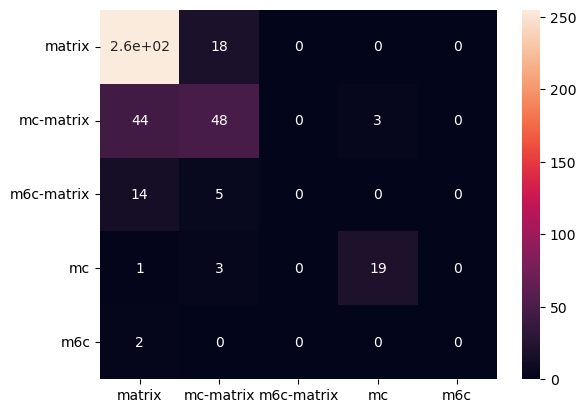

In [28]:
cm = confusion_matrix(y_val.Y, X_val.predictions_encoded)
labels= {
    'matrix': 0,
    'mc-matrix': 1,
    'm6c-matrix': 2,
    'mc': 3,
    'm6c': 4,}
sns.heatmap(cm, annot=True,xticklabels=labels, yticklabels=labels)

SV


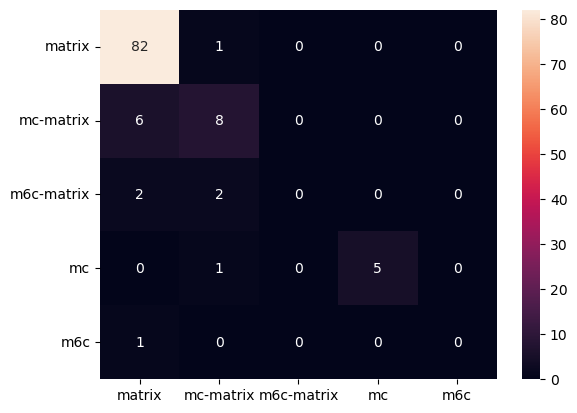

LCV


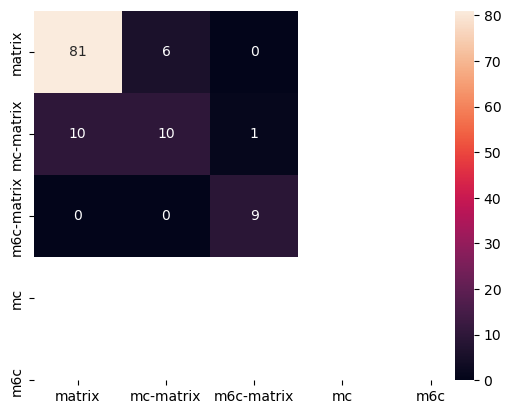

SAV


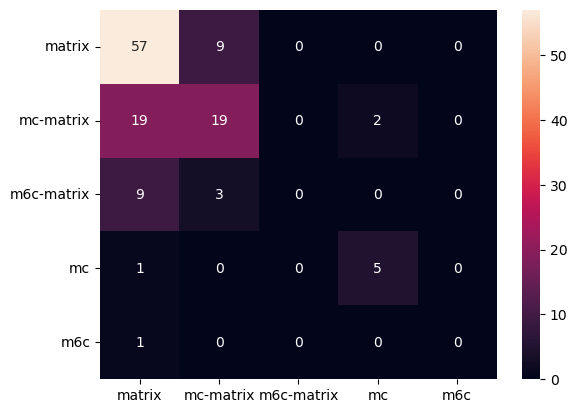

BV


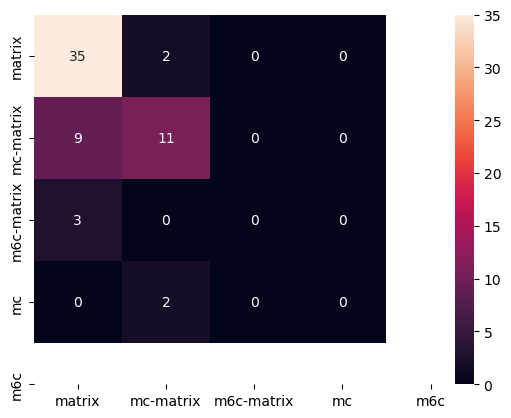

In [29]:
for material in X_val.material.unique():
    print(material)
    y_train_material = y_val[X_val.material == material]
    X_val_material = X_val[X_val.material == material]
    cm = confusion_matrix(y_train_material.Y, X_val_material.predictions_encoded)
    labels= {
        'matrix': 0,
        'mc-matrix': 1,
        'm6c-matrix': 2,
        'mc': 3,
        'm6c': 4,}
    sns.heatmap(cm, annot=True,xticklabels=labels, yticklabels=labels)
    plt.show()